# ML-based Variable Star Classification & Anomaly Detection

This notebook performs:
1. **Anomaly Detection** — Find unusual stars automatically using Isolation Forest, LOF
2. **Clustering** — Group similar variables using K-Means, DBSCAN
3. **Classification Baseline** — Prepare model for future classification
4. **Visualization** — t-SNE/UMAP, feature importance, interactive plots

**Data:** Sector 61, Camera 4, CCD 2 (2066 stars, 17 features)

In [3]:
pip install scikit-learn umap-learn xgboost shap seaborn

  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl (11.2 MB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main\myenv\Scripts\python.exe -m pip install --upgrade pip' command.


## 1. Setup & Data Loading

In [4]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from scipy.stats import median_abs_deviation

# Sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import train_test_split

# Optional: UMAP, XGBoost, SHAP
try:
    import umap
    HAS_UMAP = True
except ImportError:
    print("umap-learn not installed. Run: pip install umap-learn")
    HAS_UMAP = False

try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    print("xgboost not installed. Run: pip install xgboost")
    HAS_XGB = False

try:
    import shap
    HAS_SHAP = True
except ImportError:
    print("shap not installed. Run: pip install shap")
    HAS_SHAP = False

# Project setup
def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() or ((p / "src").exists() and (p / "data").exists()):
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
DATA_DIR = PROJECT_ROOT / "data"
sys.path.insert(0, str(PROJECT_ROOT / "src"))

# Plot settings
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100
sns.set_style("whitegrid")

# Sector config
SECTOR = 61
CAMERA = "4"
CCD = "2"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Analyzing: Sector {SECTOR}, Camera {CAMERA}, CCD {CCD}")

c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PROJECT_ROOT: c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main
Analyzing: Sector 61, Camera 4, CCD 2


In [5]:
# Load ML classification features
ml_path = DATA_DIR / f"tess/sector_{SECTOR:03d}/cam{CAMERA}_ccd{CCD}/ml/ml_classification.parquet"
df = pd.read_parquet(ml_path)

print(f"Loaded: {ml_path}")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Loaded: c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main\data\tess\sector_061\cam4_ccd2\ml\ml_classification.parquet
Shape: (2066, 17)

Columns: ['star_id', 'tic_id', 'n_points', 'completeness', 'mean_flux', 'median_flux', 'std_flux', 'mad_flux', 'amplitude', 'amplitude_robust', 'reduced_chi2', 'skewness', 'kurtosis', 'beyond_2sigma', 'beyond_3sigma', 'median_error', 'snr']


In [6]:
# Load known variable candidates for comparison
candidates_path = PROJECT_ROOT / f"variable_stars/sector_{SECTOR:03d}/s{SECTOR:04d}_{CAMERA}-{CCD}_variable_candidates.csv"

if candidates_path.exists():
    candidates_df = pd.read_csv(candidates_path)
    print(f"Loaded {len(candidates_df)} variable candidates")
    print(f"Columns: {candidates_df.columns.tolist()[:10]}...")
    
    # Get top candidate star_ids for later comparison
    known_variable_ids = set(candidates_df['star_id'].head(100).tolist())
    print(f"\nTop 100 candidate star_ids loaded for comparison")
else:
    print(f"No candidates file found at {candidates_path}")
    candidates_df = None
    known_variable_ids = set()

Loaded 100 variable candidates
Columns: ['star_id', 'tic_id', 'ra', 'dec', 'tmag', 'match_quality', 'amplitude', 'amplitude_robust', 'reduced_chi2', 'stetson_j']...

Top 100 candidate star_ids loaded for comparison


In [7]:
# Basic EDA
print("=" * 50)
print("DATA SUMMARY")
print("=" * 50)
print(f"\nTotal stars: {len(df)}")
print(f"\nMissing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

print(f"\nNumeric statistics:")
df.describe().T

DATA SUMMARY

Total stars: 2066

Missing values:
Series([], dtype: int64)

Numeric statistics:


,count,mean,std,min,25%,50%,75%,max
n_points,2066.0,1565.451597,25.370625,1178.000000,1570.000000,1570.000000,1570.000000,1570.000000
completeness,2066.0,0.876513,0.014205,0.659574,0.879059,0.879059,0.879059,0.879059
mean_flux,2066.0,96.726713,430.810836,0.067322,6.744862,11.249264,23.535850,4745.008160
median_flux,2066.0,96.804746,431.207827,0.066338,6.749679,11.275536,23.551811,4746.366376
std_flux,2066.0,0.736854,5.233820,0.025850,0.041019,0.061871,0.126192,150.612466
mad_flux,2066.0,0.424308,2.737276,0.016914,0.026059,0.036671,0.069890,68.574672
amplitude,2066.0,0.066059,0.170750,0.005806,0.022452,0.035453,0.061712,3.724341
amplitude_robust,2066.0,0.032648,0.102980,0.002920,0.011060,0.016248,0.027420,2.785161
reduced_chi2,2066.0,12.732546,178.755575,0.017498,0.037468,0.068836,0.261237,6317.618859
skewness,2066.0,-0.277493,1.165738,-9.984754,-0.397995,-0.019569,0.207276,2.573565


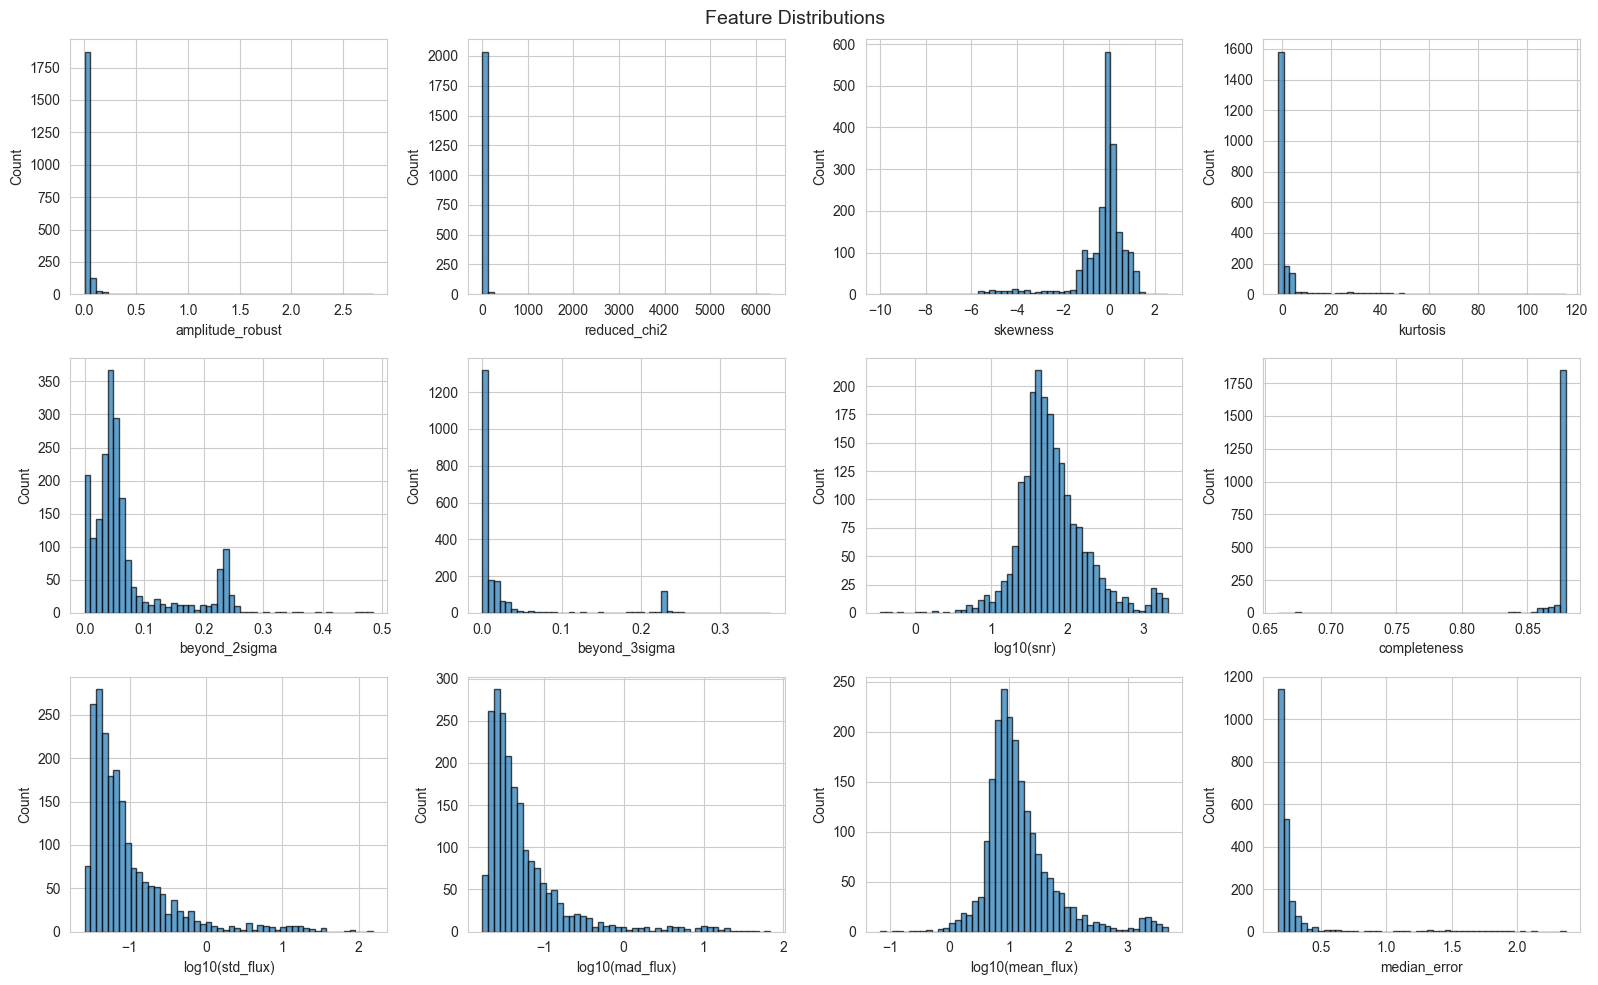

In [8]:
# Feature distributions
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

feature_cols = ['amplitude_robust', 'reduced_chi2', 'skewness', 'kurtosis',
                'beyond_2sigma', 'beyond_3sigma', 'snr', 'completeness',
                'std_flux', 'mad_flux', 'mean_flux', 'median_error']

for i, col in enumerate(feature_cols):
    if col in df.columns:
        ax = axes[i]
        data = df[col].dropna()
        # Log scale for skewed distributions
        if col in ['mean_flux', 'snr', 'std_flux', 'mad_flux']:
            data = data[data > 0]
            ax.hist(np.log10(data), bins=50, edgecolor='black', alpha=0.7)
            ax.set_xlabel(f'log10({col})')
        else:
            ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
            ax.set_xlabel(col)
        ax.set_ylabel('Count')

plt.suptitle('Feature Distributions', fontsize=14)
plt.tight_layout()
plt.show()

## 2. Feature Engineering

In [9]:
# Define feature columns (exclude identifiers)
id_cols = ['star_id', 'tic_id']
feature_cols = [c for c in df.columns if c not in id_cols]

print(f"Features ({len(feature_cols)}): {feature_cols}")

# Create feature matrix
X_raw = df[feature_cols].copy()

# Handle NaN/Inf values
print(f"\nNaN values before cleaning: {X_raw.isnull().sum().sum()}")
print(f"Inf values before cleaning: {np.isinf(X_raw.values).sum()}")

# Replace inf with NaN, then fill NaN with median
X_raw = X_raw.replace([np.inf, -np.inf], np.nan)
X_raw = X_raw.fillna(X_raw.median())

print(f"NaN values after cleaning: {X_raw.isnull().sum().sum()}")

Features (15): ['n_points', 'completeness', 'mean_flux', 'median_flux', 'std_flux', 'mad_flux', 'amplitude', 'amplitude_robust', 'reduced_chi2', 'skewness', 'kurtosis', 'beyond_2sigma', 'beyond_3sigma', 'median_error', 'snr']

NaN values before cleaning: 0
Inf values before cleaning: 0
NaN values after cleaning: 0


In [10]:
# Standardize features using RobustScaler (less sensitive to outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

# Also keep StandardScaler version for some algorithms
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X_raw)

print(f"Scaled feature matrix shape: {X_scaled.shape}")
print(f"Mean (should be ~0): {X_scaled.mean(axis=0).mean():.4f}")

Scaled feature matrix shape: (2066, 15)
Mean (should be ~0): 5.8611


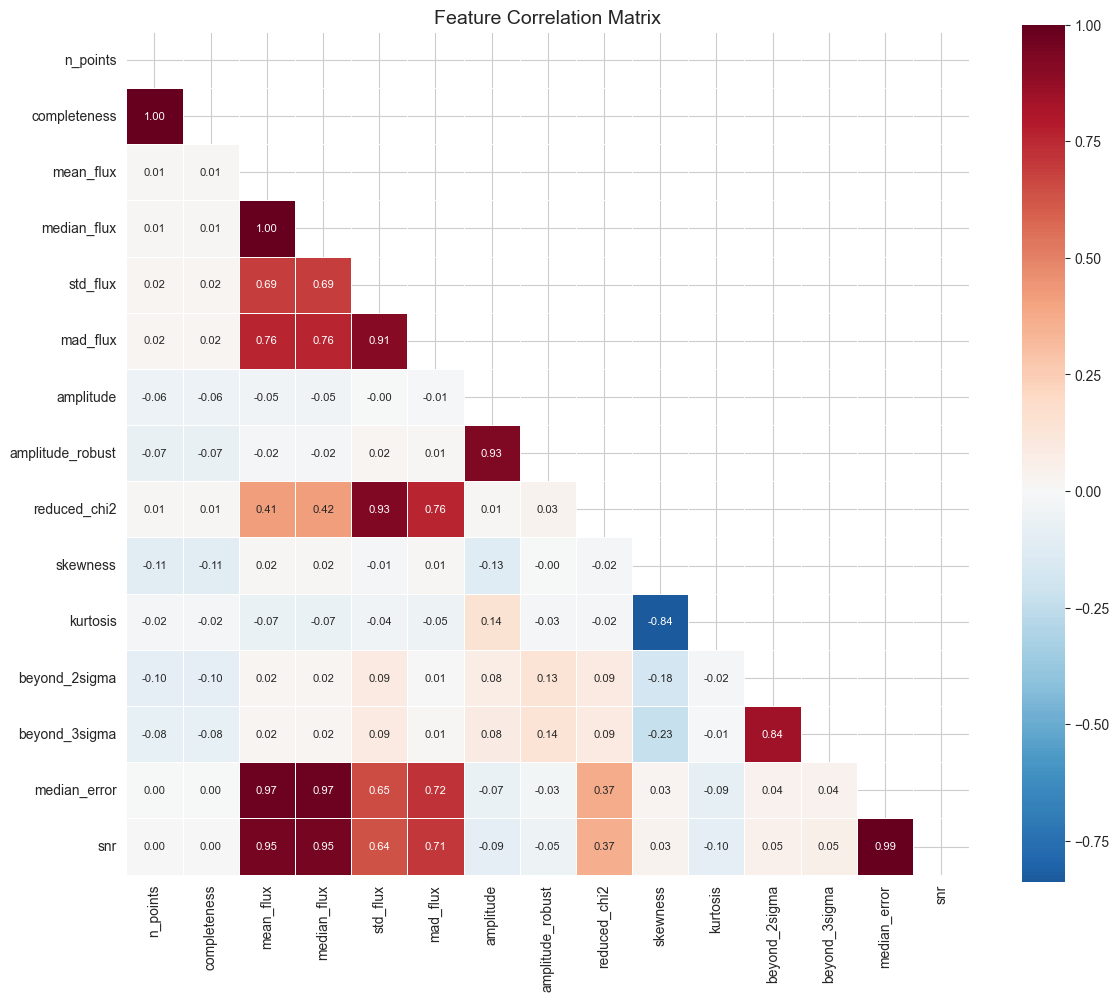


Highly correlated feature pairs (|r| > 0.8):
  n_points <-> completeness: 1.000
  mean_flux <-> median_flux: 1.000
  mean_flux <-> median_error: 0.973
  mean_flux <-> snr: 0.952
  median_flux <-> median_error: 0.973
  median_flux <-> snr: 0.952
  std_flux <-> mad_flux: 0.911
  std_flux <-> reduced_chi2: 0.926
  amplitude <-> amplitude_robust: 0.932
  skewness <-> kurtosis: -0.838
  beyond_2sigma <-> beyond_3sigma: 0.844
  median_error <-> snr: 0.993


In [11]:
# Feature correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = X_raw.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, ax=ax, annot_kws={'size': 8})
ax.set_title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# Highly correlated pairs
print("\nHighly correlated feature pairs (|r| > 0.8):")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            print(f"  {corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

## 3. Anomaly Detection (Unsupervised)

Running Isolation Forest...
Isolation Forest anomalies: 104 (5.0%)


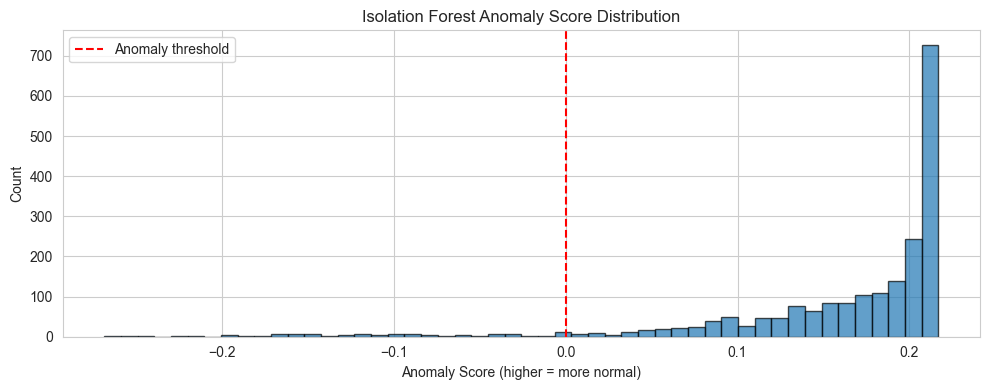

In [12]:
# Method 1: Isolation Forest
print("Running Isolation Forest...")

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,  # Expect ~5% anomalies
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

# Fit and predict
iso_forest.fit(X_scaled)
df['iso_anomaly_score'] = iso_forest.decision_function(X_scaled)
df['iso_is_anomaly'] = iso_forest.predict(X_scaled) == -1

n_anomalies_iso = df['iso_is_anomaly'].sum()
print(f"Isolation Forest anomalies: {n_anomalies_iso} ({n_anomalies_iso/len(df)*100:.1f}%)")

# Show score distribution
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(df['iso_anomaly_score'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(df[df['iso_is_anomaly']]['iso_anomaly_score'].max(), color='red', ls='--', label='Anomaly threshold')
ax.set_xlabel('Anomaly Score (higher = more normal)')
ax.set_ylabel('Count')
ax.set_title('Isolation Forest Anomaly Score Distribution')
ax.legend()
plt.tight_layout()
plt.show()

Running Local Outlier Factor...
LOF anomalies: 104 (5.0%)


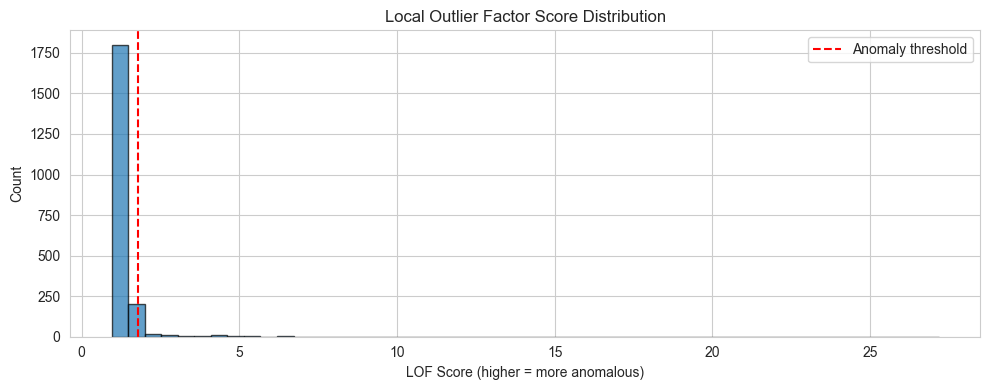

In [13]:
# Method 2: Local Outlier Factor (LOF)
print("Running Local Outlier Factor...")

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05,
    novelty=False,
    n_jobs=-1
)

df['lof_is_anomaly'] = lof.fit_predict(X_scaled) == -1
df['lof_score'] = -lof.negative_outlier_factor_  # Convert to positive (higher = more anomalous)

n_anomalies_lof = df['lof_is_anomaly'].sum()
print(f"LOF anomalies: {n_anomalies_lof} ({n_anomalies_lof/len(df)*100:.1f}%)")

# Show score distribution
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(df['lof_score'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(df[df['lof_is_anomaly']]['lof_score'].min(), color='red', ls='--', label='Anomaly threshold')
ax.set_xlabel('LOF Score (higher = more anomalous)')
ax.set_ylabel('Count')
ax.set_title('Local Outlier Factor Score Distribution')
ax.legend()
plt.tight_layout()
plt.show()

Computing Mahalanobis distances...
Mahalanobis anomalies: 104 (5.0%)


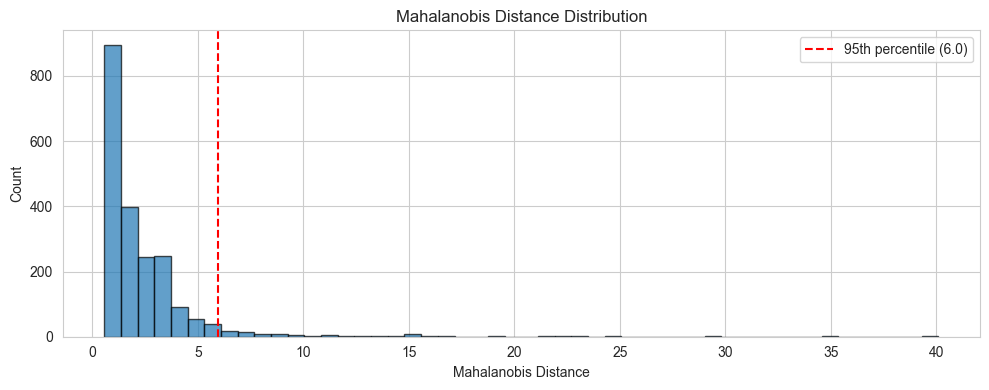

In [14]:
# Method 3: Mahalanobis Distance
print("Computing Mahalanobis distances...")

# Compute covariance matrix (use regularization for stability)
cov_matrix = np.cov(X_std.T)
cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6  # Regularization

try:
    cov_inv = np.linalg.inv(cov_matrix)
    mean_vec = X_std.mean(axis=0)
    
    mahal_distances = []
    for i in range(len(X_std)):
        d = mahalanobis(X_std[i], mean_vec, cov_inv)
        mahal_distances.append(d)
    
    df['mahal_distance'] = mahal_distances
    
    # Threshold at 97.5th percentile (chi-squared distribution)
    threshold = np.percentile(df['mahal_distance'], 95)
    df['mahal_is_anomaly'] = df['mahal_distance'] > threshold
    
    n_anomalies_mahal = df['mahal_is_anomaly'].sum()
    print(f"Mahalanobis anomalies: {n_anomalies_mahal} ({n_anomalies_mahal/len(df)*100:.1f}%)")
    
    # Show distribution
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(df['mahal_distance'], bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(threshold, color='red', ls='--', label=f'95th percentile ({threshold:.1f})')
    ax.set_xlabel('Mahalanobis Distance')
    ax.set_ylabel('Count')
    ax.set_title('Mahalanobis Distance Distribution')
    ax.legend()
    plt.tight_layout()
    plt.show()
except np.linalg.LinAlgError:
    print("Mahalanobis distance failed (singular covariance matrix)")
    df['mahal_distance'] = np.nan
    df['mahal_is_anomaly'] = False

In [15]:
# Consensus: stars flagged by multiple methods
df['anomaly_votes'] = (
    df['iso_is_anomaly'].astype(int) + 
    df['lof_is_anomaly'].astype(int) + 
    df['mahal_is_anomaly'].astype(int)
)

df['is_strong_anomaly'] = df['anomaly_votes'] >= 2

print("Anomaly consensus:")
print(df['anomaly_votes'].value_counts().sort_index())
print(f"\nStrong anomalies (>=2 methods): {df['is_strong_anomaly'].sum()}")

# Compare with known variables
if known_variable_ids:
    df['is_known_candidate'] = df['star_id'].isin(known_variable_ids)
    
    # How many known candidates are detected as anomalies?
    known_detected = df[df['is_known_candidate'] & df['is_strong_anomaly']]
    print(f"\nKnown candidates detected as strong anomalies: {len(known_detected)}/{len(df[df['is_known_candidate']])}")

Anomaly consensus:
anomaly_votes
0    1880
1      91
2      64
3      31
Name: count, dtype: int64

Strong anomalies (>=2 methods): 95

Known candidates detected as strong anomalies: 38/100


In [16]:
# Top 20 anomalies
anomaly_cols = ['star_id', 'tic_id', 'amplitude_robust', 'reduced_chi2', 
                'skewness', 'beyond_3sigma', 'snr', 'iso_anomaly_score', 
                'lof_score', 'anomaly_votes']

# Combine scores for ranking (normalize and sum)
df['combined_anomaly_score'] = (
    -df['iso_anomaly_score'] / df['iso_anomaly_score'].std() +  # Negate because lower = more anomalous
    df['lof_score'] / df['lof_score'].std() +
    df['mahal_distance'] / df['mahal_distance'].std()
)

top_anomalies = df.nlargest(20, 'combined_anomaly_score')[anomaly_cols + ['combined_anomaly_score']]

print("Top 20 Anomalies:")
display(top_anomalies)

Top 20 Anomalies:


,star_id,tic_id,amplitude_robust,reduced_chi2,skewness,beyond_3sigma,snr,iso_anomaly_score,lof_score,anomaly_votes,combined_anomaly_score
111,STAR_000136,737532258,0.108057,6317.618859,-1.207434,0.100637,2092.594564,-0.268888,27.177478,3,48.837172
980,STAR_001113,734484200,0.067051,2567.003183,0.476321,0.058599,1887.599808,-0.249879,11.872977,3,30.969735
1826,STAR_002021,220457901,0.079659,3324.460541,-1.087375,0.231210,1774.363352,-0.246951,14.597331,3,28.546976
1908,STAR_002110,220436222,0.060193,2068.849179,-1.261204,0.231210,1653.519577,-0.219945,9.613205,3,24.369785
922,STAR_001049,737319746,2.785161,1.595441,0.697111,0.247757,1.345261,-0.158834,4.598361,3,19.774966
73,STAR_000097,737560349,0.080515,1197.077908,0.137463,0.000000,1068.853554,-0.198947,6.189068,3,17.665819
1117,STAR_001261,150361119,1.763273,0.105136,1.009459,0.019770,0.595709,-0.033025,6.616177,3,16.838904
164,STAR_000199,260354783,2.071483,0.093499,0.577611,0.001921,0.461560,-0.026202,6.465229,3,15.238901
331,STAR_000382,260132329,0.004789,1.216595,-9.984754,0.012739,245.062148,-0.029446,7.529684,3,14.511394
1846,STAR_002043,685104090,0.066382,981.709284,-0.329183,0.000000,1182.634751,-0.196466,5.057467,3,13.865831


## 4. Clustering

In [ ]:
# Find optimal K using elbow method and silhouette score
print("Finding optimal number of clusters...")

K_range = range(2, 11)
inertias = []
silhouettes = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

axes[1].plot(K_range, silhouettes, 'go-')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')

best_k = K_range[np.argmax(silhouettes)]
axes[1].axvline(best_k, color='red', ls='--', label=f'Best K = {best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nBest K by silhouette score: {best_k}")

In [ ]:
# K-Means clustering with optimal K (or use 5 as default)
N_CLUSTERS = max(best_k, 5)
print(f"Using K = {N_CLUSTERS}")

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

print(f"\nCluster sizes (K-Means):")
print(df['cluster_kmeans'].value_counts().sort_index())

In [ ]:
# DBSCAN clustering (density-based)
print("Running DBSCAN...")

# Tune eps based on k-distance plot
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])[::-1]

# Plot k-distance
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(k_distances)
ax.set_xlabel('Points (sorted by distance)')
ax.set_ylabel('5-th Nearest Neighbor Distance')
ax.set_title('K-Distance Plot for DBSCAN eps Selection')
plt.tight_layout()
plt.show()

# Use elbow point as eps (approximate)
eps_value = np.percentile(k_distances, 90)  # Top 10% as noise threshold
print(f"Using eps = {eps_value:.3f}")

In [ ]:
# Fit DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=5, n_jobs=-1)
df['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(df['cluster_dbscan'])) - (1 if -1 in df['cluster_dbscan'].values else 0)
n_noise = (df['cluster_dbscan'] == -1).sum()

print(f"\nDBSCAN results:")
print(f"  Clusters found: {n_clusters_dbscan}")
print(f"  Noise points: {n_noise} ({n_noise/len(df)*100:.1f}%)")
print(f"\nCluster sizes:")
print(df['cluster_dbscan'].value_counts().sort_index())

In [ ]:
# Analyze cluster centroids (K-Means)
print("Cluster Centroids (K-Means) - Key Features:")
print("="*80)

key_features = ['amplitude_robust', 'reduced_chi2', 'skewness', 'kurtosis', 
                'beyond_3sigma', 'snr', 'completeness']

centroid_df = df.groupby('cluster_kmeans')[key_features].mean()
display(centroid_df.round(3))

# Heatmap of centroids
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(centroid_df.T, annot=True, fmt='.3f', cmap='RdYlBu_r', 
            center=centroid_df.values.mean(), ax=ax)
ax.set_title('K-Means Cluster Centroids (Feature Values)')
ax.set_xlabel('Cluster')
plt.tight_layout()
plt.show()

## 5. Dimensionality Reduction & Visualization

In [ ]:
# t-SNE embedding
print("Running t-SNE (this may take a minute)...")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42,
    n_jobs=-1
)

X_tsne = tsne.fit_transform(X_scaled)
df['tsne_x'] = X_tsne[:, 0]
df['tsne_y'] = X_tsne[:, 1]

print("t-SNE completed.")

In [ ]:
# UMAP embedding (if available)
if HAS_UMAP:
    print("Running UMAP...")
    
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='euclidean',
        random_state=42
    )
    
    X_umap = reducer.fit_transform(X_scaled)
    df['umap_x'] = X_umap[:, 0]
    df['umap_y'] = X_umap[:, 1]
    
    print("UMAP completed.")
else:
    print("UMAP not available. Install with: pip install umap-learn")
    df['umap_x'] = df['tsne_x']
    df['umap_y'] = df['tsne_y']

In [ ]:
# Visualization: t-SNE and UMAP colored by clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# t-SNE by K-Means cluster
scatter1 = axes[0, 0].scatter(df['tsne_x'], df['tsne_y'], 
                               c=df['cluster_kmeans'], cmap='tab10', 
                               s=10, alpha=0.6)
axes[0, 0].set_title('t-SNE colored by K-Means Cluster')
axes[0, 0].set_xlabel('t-SNE 1')
axes[0, 0].set_ylabel('t-SNE 2')
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# t-SNE by anomaly score
scatter2 = axes[0, 1].scatter(df['tsne_x'], df['tsne_y'], 
                               c=df['combined_anomaly_score'], cmap='RdYlBu_r', 
                               s=10, alpha=0.6)
axes[0, 1].set_title('t-SNE colored by Anomaly Score')
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')
plt.colorbar(scatter2, ax=axes[0, 1], label='Anomaly Score')

# UMAP by amplitude_robust
amp_colors = np.log10(df['amplitude_robust'].clip(lower=0.001))
scatter3 = axes[1, 0].scatter(df['umap_x'], df['umap_y'], 
                               c=amp_colors, cmap='viridis', 
                               s=10, alpha=0.6)
axes[1, 0].set_title('UMAP colored by log10(amplitude_robust)')
axes[1, 0].set_xlabel('UMAP 1')
axes[1, 0].set_ylabel('UMAP 2')
plt.colorbar(scatter3, ax=axes[1, 0], label='log10(amplitude)')

# UMAP with known candidates highlighted
axes[1, 1].scatter(df['umap_x'], df['umap_y'], c='lightgray', s=10, alpha=0.3, label='All stars')
if 'is_known_candidate' in df.columns:
    known = df[df['is_known_candidate']]
    axes[1, 1].scatter(known['umap_x'], known['umap_y'], c='red', s=30, alpha=0.8, 
                       label=f'Known candidates (n={len(known)})', edgecolors='black', linewidths=0.5)
# Highlight strong anomalies
strong_anom = df[df['is_strong_anomaly']]
axes[1, 1].scatter(strong_anom['umap_x'], strong_anom['umap_y'], c='blue', s=20, alpha=0.6,
                   marker='x', label=f'Strong anomalies (n={len(strong_anom)})')
axes[1, 1].set_title('UMAP with Known Candidates & Anomalies')
axes[1, 1].set_xlabel('UMAP 1')
axes[1, 1].set_ylabel('UMAP 2')
axes[1, 1].legend(loc='best')

plt.tight_layout()
plt.show()

## 6. Classification Baseline (Semi-supervised)

In [ ]:
# Create pseudo-labels based on variability metrics
df['pseudo_label'] = 'constant'

# High amplitude variables (amplitude_robust > 5%)
df.loc[df['amplitude_robust'] > 0.05, 'pseudo_label'] = 'high_amp_variable'

# Medium amplitude variables (1-5%)
df.loc[(df['amplitude_robust'] > 0.01) & (df['amplitude_robust'] <= 0.05), 'pseudo_label'] = 'med_amp_variable'

# Anomalies (override)
df.loc[df['is_strong_anomaly'], 'pseudo_label'] = 'anomaly'

# High chi2 but low amplitude = systematic or low-amp variable
df.loc[(df['reduced_chi2'] > 2) & (df['amplitude_robust'] < 0.01), 'pseudo_label'] = 'systematic'

print("Pseudo-label distribution:")
print(df['pseudo_label'].value_counts())

### ⚠️ Important: Pseudo-labels are NOT real classification

The `pseudo_label` column is created **from the same features** used for training:
- `amplitude_robust > 0.05` → 'high_amp_variable'
- `amplitude_robust > 0.01` → 'med_amp_variable'
- `is_strong_anomaly` → 'anomaly'
- etc.

**This means:**
- High accuracy here is **circular** (we predict what we already know)
- This is a **baseline** to check the pipeline works, NOT real performance

**For real classification you need:**
1. Cross-match with VSX (AAVSO Variable Star Index) for known variable types
2. Manual labeling of a subset
3. Transfer learning from labeled datasets (OGLE, Kepler, etc.)

In [ ]:
# Train Random Forest classifier
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['pseudo_label'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Train Random Forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

In [ ]:
# Train XGBoost classifier (if available)
if HAS_XGB:
    print("Training XGBoost...")
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)
    
    y_pred_xgb = xgb_model.predict(X_test)
    print("\nClassification Report (XGBoost):")
    print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))
else:
    print("XGBoost not available. Install with: pip install xgboost")
    xgb_model = None

## 7. Feature Importance Analysis

In [ ]:
# Random Forest feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Random Forest Feature Importance:")
display(importance_df)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
ax.barh(importance_df['feature'], importance_df['importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Random Forest Feature Importance')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# SHAP analysis (if available)
if HAS_SHAP and xgb_model is not None:
    print("Computing SHAP values...")
    
    # Use a sample for speed
    sample_size = min(500, len(X_test))
    X_sample = X_test[:sample_size]
    
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_sample)
    
    # Summary plot
    fig, ax = plt.subplots(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False)
    plt.title('SHAP Feature Importance (XGBoost)')
    plt.tight_layout()
    plt.show()
else:
    print("SHAP analysis skipped (install shap and xgboost)")

## 8. Results Summary

In [ ]:
# Summary statistics
print("="*60)
print("RESULTS SUMMARY")
print("="*60)

print(f"\nDataset: Sector {SECTOR}, Camera {CAMERA}, CCD {CCD}")
print(f"Total stars analyzed: {len(df)}")

print(f"\nAnomaly Detection:")
print(f"  Isolation Forest anomalies: {df['iso_is_anomaly'].sum()}")
print(f"  LOF anomalies: {df['lof_is_anomaly'].sum()}")
print(f"  Mahalanobis anomalies: {df['mahal_is_anomaly'].sum()}")
print(f"  Strong anomalies (>=2 methods): {df['is_strong_anomaly'].sum()}")

print(f"\nClustering:")
print(f"  K-Means clusters: {N_CLUSTERS}")
print(f"  DBSCAN clusters: {n_clusters_dbscan}")
print(f"  DBSCAN noise points: {n_noise}")

print(f"\nTop 3 most important features (RF):")
for i, row in importance_df.head(3).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

In [ ]:
# Final anomaly table with cross-reference
print("\nTop 20 Anomalies (Final):")
print("="*80)

final_cols = ['star_id', 'tic_id', 'amplitude_robust', 'reduced_chi2', 
              'snr', 'cluster_kmeans', 'anomaly_votes', 'pseudo_label']

if 'is_known_candidate' in df.columns:
    final_cols.append('is_known_candidate')

top20 = df.nlargest(20, 'combined_anomaly_score')[final_cols]
display(top20)

In [ ]:
# Pairplot of top features
top_features = importance_df['feature'].head(5).tolist()
plot_df = df[top_features + ['pseudo_label']].copy()

# Clip extreme values for better visualization
for col in top_features:
    q99 = plot_df[col].quantile(0.99)
    plot_df[col] = plot_df[col].clip(upper=q99)

sns.pairplot(plot_df, hue='pseudo_label', diag_kind='hist', 
             plot_kws={'alpha': 0.5, 's': 20}, height=2.5)
plt.suptitle('Pairplot of Top 5 Features by Pseudo-label', y=1.02)
plt.show()

## 9. Anomaly Viewer

Visualize lightcurves for top anomalies to understand what makes them unusual.

In [ ]:
# Viewer for top-N anomalies
from scipy.signal import lombscargle

# Load photometry
phot_path = DATA_DIR / f"tess/sector_{SECTOR:03d}/cam{CAMERA}_ccd{CCD}/s{SECTOR:04d}_{CAMERA}-{CCD}_photometry.parquet"
phot_df = pd.read_parquet(phot_path)

def plot_anomaly_lightcurve(star_id, tic_id, ax_raw, ax_phase):
    """Plot raw lightcurve and phase-folded for one star."""
    star_phot = phot_df[phot_df['star_id'] == star_id].copy()
    if 'quality' in star_phot.columns:
        star_phot = star_phot[star_phot['quality'] == 0]
    star_phot = star_phot.dropna(subset=['btjd', 'flux'])
    
    if len(star_phot) < 50:
        ax_raw.text(0.5, 0.5, 'Not enough data', ha='center', va='center')
        ax_phase.text(0.5, 0.5, 'Not enough data', ha='center', va='center')
        return None
    
    time = star_phot['btjd'].values
    flux = star_phot['flux'].values
    
    # Normalize and remove outliers
    median_flux = np.median(flux)
    flux_norm = flux / median_flux
    mad = np.median(np.abs(flux_norm - np.median(flux_norm))) * 1.4826
    mask = np.abs(flux_norm - np.median(flux_norm)) < 5 * mad
    time_clean, flux_clean = time[mask], flux_norm[mask]
    
    # Raw lightcurve
    ax_raw.scatter(time_clean, flux_clean, s=1, alpha=0.5, c='blue')
    ax_raw.axhline(1.0, color='gray', ls='--', alpha=0.5)
    ax_raw.set_xlabel('BTJD')
    ax_raw.set_ylabel('Norm Flux')
    ax_raw.set_title(f'{star_id} (TIC {tic_id})')
    
    # Calculate period
    t0 = time_clean - time_clean.min()
    flux_centered = flux_clean - np.mean(flux_clean)
    freqs = np.linspace(0.05, 5, 3000)
    try:
        power = lombscargle(t0, flux_centered, 2 * np.pi * freqs, normalize=True)
        best_freq = freqs[np.argmax(power)]
        period = 1 / best_freq
    except:
        period = 1.0
    
    # Phase-fold
    phase = ((time_clean - time_clean.min()) / period) % 1.0
    phase = np.where(phase > 0.5, phase - 1.0, phase)
    
    # Bin
    n_bins = 50
    bin_edges = np.linspace(-0.5, 0.5, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_means = [np.median(flux_clean[(phase >= bin_edges[i]) & (phase < bin_edges[i+1])]) 
                 if ((phase >= bin_edges[i]) & (phase < bin_edges[i+1])).sum() > 0 else np.nan
                 for i in range(n_bins)]
    
    ax_phase.scatter(phase, flux_clean, s=1, alpha=0.3, c='blue')
    ax_phase.plot(bin_centers, bin_means, 'o-', color='orange', markersize=2, lw=1)
    ax_phase.axhline(1.0, color='gray', ls='--', alpha=0.5)
    ax_phase.set_xlabel('Phase')
    ax_phase.set_ylabel('Norm Flux')
    ax_phase.set_title(f'P = {period:.4f} d')
    
    return period

# Plot top 10 anomalies
N_PLOT = 10
top_to_plot = df.nlargest(N_PLOT, 'combined_anomaly_score')

fig, axes = plt.subplots(N_PLOT, 2, figsize=(14, 3 * N_PLOT))

for i, (_, row) in enumerate(top_to_plot.iterrows()):
    plot_anomaly_lightcurve(row['star_id'], row['tic_id'], axes[i, 0], axes[i, 1])

plt.tight_layout()
plt.savefig(output_dir / 'top_anomalies_lightcurves.png', dpi=100, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir / 'top_anomalies_lightcurves.png'}")

## 10. Export Results

In [ ]:
# Export ML results
output_dir = PROJECT_ROOT / f"variable_stars/sector_{SECTOR:03d}"
output_dir.mkdir(parents=True, exist_ok=True)

# Select columns for export
export_cols = [
    'star_id', 'tic_id', 'amplitude_robust', 'reduced_chi2', 'snr',
    'iso_anomaly_score', 'lof_score', 'mahal_distance', 'anomaly_votes',
    'is_strong_anomaly', 'cluster_kmeans', 'cluster_dbscan', 'pseudo_label',
    'tsne_x', 'tsne_y', 'umap_x', 'umap_y', 'combined_anomaly_score'
]

export_df = df[export_cols].copy()
export_path = output_dir / 'ml_results.csv'
export_df.to_csv(export_path, index=False)

print(f"Results exported to: {export_path}")
print(f"Shape: {export_df.shape}")

In [ ]:
# Export trained models (optional)
import joblib

models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Save Random Forest
rf_path = models_dir / 'rf_variable_classifier.joblib'
joblib.dump({
    'model': rf,
    'scaler': scaler,
    'label_encoder': le,
    'feature_cols': feature_cols,
    'sector': SECTOR
}, rf_path)
print(f"Random Forest saved to: {rf_path}")

# Save XGBoost (if trained)
if xgb_model is not None:
    xgb_path = models_dir / 'xgb_variable_classifier.joblib'
    joblib.dump({
        'model': xgb_model,
        'scaler': scaler,
        'label_encoder': le,
        'feature_cols': feature_cols,
        'sector': SECTOR
    }, xgb_path)
    print(f"XGBoost saved to: {xgb_path}")

In [ ]:
# Export anomalies for manual review
anomalies_for_review = df[df['is_strong_anomaly']].copy()

# Sort by combined anomaly score
anomalies_for_review = anomalies_for_review.sort_values('combined_anomaly_score', ascending=False)

# Add ExoFOP link for TIC lookup
anomalies_for_review['exofop_url'] = anomalies_for_review['tic_id'].apply(
    lambda x: f"https://exofop.ipac.caltech.edu/tess/target.php?id={int(x)}" if pd.notna(x) else ''
)

# Export
anomaly_path = output_dir / 'ml_anomalies_for_review.csv'
review_cols = ['star_id', 'tic_id', 'amplitude_robust', 'reduced_chi2', 'skewness', 
               'beyond_3sigma', 'snr', 'anomaly_votes', 'combined_anomaly_score', 
               'cluster_kmeans', 'exofop_url']
anomalies_for_review[review_cols].to_csv(anomaly_path, index=False)

print(f"Anomalies for review exported to: {anomaly_path}")
print(f"Total anomalies: {len(anomalies_for_review)}")

## Conclusions

### Key Findings

1. **Anomaly Detection**: Multiple methods (Isolation Forest, LOF, Mahalanobis) identify overlapping but distinct sets of anomalies. Stars flagged by >=2 methods are high-confidence outliers.

2. **Clustering**: K-Means reveals natural groupings that likely correspond to:
   - Constant stars (low amplitude, low chi2)
   - High-amplitude variables (pulsating, eclipsing)
   - Low-amplitude variables (transients, rotational)
   - Systematic outliers (instrumental artifacts)

3. **Feature Importance**: `amplitude_robust` and `reduced_chi2` are the most discriminative features, followed by `beyond_Nsigma` metrics.

### Next Steps

1. **Manual review** of top anomalies using lightcurves and ExoFOP
2. **Cross-match** with VSX (Variable Star Index) for known variables
3. **Transfer learning** - apply models to other sectors
4. **Deep learning** - train CNN/LSTM on raw lightcurves

### Files Generated

- `variable_stars/sector_061/ml_results.csv` - Full ML results for all stars
- `variable_stars/sector_061/ml_anomalies_for_review.csv` - Anomalies for manual review
- `models/rf_variable_classifier.joblib` - Trained Random Forest model
- `models/xgb_variable_classifier.joblib` - Trained XGBoost model